In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/koreansteel.xlsx", sheet_name="South Korea - Dongkuk Steel Mil", index_col='Date', parse_dates=['Date'])

In [3]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,13650,13700,13750,13450,0.19K,0.0000
2021-03-30,13650,13850,14200,13050,3.17M,0.0074
2021-03-29,13550,12500,13800,12500,0.20K,0.1107
2021-03-28,12200,12200,12200,12200,-,0.0000
2021-03-26,12200,11500,12300,11350,2.34M,0.0796


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341 entries, 2021-03-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     341 non-null    int64  
 1   Open      341 non-null    int64  
 2   High      341 non-null    int64  
 3   Low       341 non-null    int64  
 4   Vol.      341 non-null    object 
 5   Change %  341 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 18.6+ KB


In [5]:
# Replacing the Million-'M', Thousand -'k', and '-' terms in Volume feature
#  and splitting the dataset into 2020 data for training and 2021 data for testing.
def preprocess(data):
    data['Vol.'] = data['Vol.'].str.replace('-', '0').str.replace('M', '').str.replace('K', 'e3').astype(float)
    data['Vol.'] *= 1e6
    data['Change %'] = data['Change %'].abs()
    return data

In [6]:
data = preprocess(df)

In [7]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,13650,13700,13750,13450,190000000.0,0.0000
2021-03-30,13650,13850,14200,13050,3170000.0,0.0074
2021-03-29,13550,12500,13800,12500,200000000.0,0.1107
2021-03-28,12200,12200,12200,12200,0.0,0.0000
2021-03-26,12200,11500,12300,11350,2340000.0,0.0796


In [8]:
stock_prices = data['Price']

In [9]:
# Define a function to calculate Bollinger Bands
def calculate_bollinger_bands(prices, window, num_std):
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return rolling_mean, upper_band, lower_band

In [10]:
rolling_mean,upper_band,lower_band = calculate_bollinger_bands(stock_prices,window=20,num_std=2)

In [11]:
signals = pd.DataFrame(index=df.index)
signals['Price'] = df['Price']
signals['Middle Band'] = rolling_mean
signals['Upper Band'] = upper_band
signals['Lower Band'] = lower_band

In [13]:
def generate_signals(data):
    signals = []
    position = 0  # 0 for no position, 1 for long, -1 for short
    capital = 100000  # Initial capital in dollars
    shares = 0  # Number of shares held
    num_trades = 0  # Number of trades
    for i in range(len(data)):
        if data['Price'][i] > data['Upper Band'][i]:
            if position != -1:  # Close any existing short position
                shares += position
                capital += position * data['Price'][i]
                position = -1
                signals.append(('SELL', data.index[i]))
                num_trades += 1
            else:
                signals.append(('HOLD', data.index[i]))
        elif data['Price'][i] < data['Lower Band'][i]:
            if position != 1:  # Close any existing long position
                position = 1
                shares += position
                capital += position * data['Price'][i]
                signals.append(('BUY', data.index[i]))
                num_trades += 1
            else:
                signals.append(('HOLD', data.index[i]))
        else:
            signals.append(('HOLD', data.index[i]))
    # Calculate final capital
    final_value = capital + shares * data['Price'].iloc[-1]
    return signals, final_value, num_trades

In [14]:
strategy_signals, final_capital, num_trades = generate_signals(signals)

Buy signal on 2021-03-02 00:00:00
Sell signal on 2020-11-24 00:00:00
Buy signal on 2020-11-22 00:00:00
Sell signal on 2020-10-12 00:00:00
Buy signal on 2020-07-14 00:00:00
Sell signal on 2020-06-17 00:00:00
Buy signal on 2020-06-02 00:00:00
Sell signal on 2020-03-06 00:00:00
Initial Capital: $100,000
Final Capital: $198820.00
Capital Returns: 98.82%
Number of Trades: 8


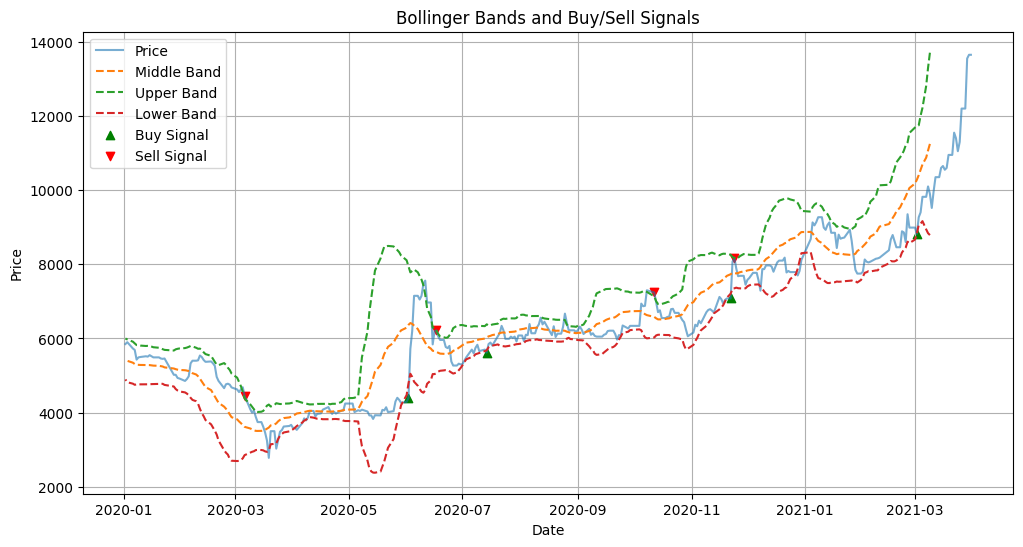

In [16]:
# Print buy and sell signals
for signal, date in strategy_signals:
    if signal == 'BUY':
        print(f"Buy signal on {date}")
    elif signal == 'SELL':
        print(f"Sell signal on {date}")
# Print final capital, capital returns, and number of trades
print(f"Initial Capital: $100,000")
print(f"Final Capital: ${final_capital:.2f}")
capital_returns = (final_capital - 100000) / 100000 * 100
print(f"Capital Returns: {capital_returns:.2f}%")
print(f"Number of Trades: {num_trades}")
# Visualize Bollinger Bands and signals
plt.figure(figsize=(12, 6))
plt.plot(signals.index, signals['Price'], label='Price', alpha=0.6)
plt.plot(signals.index, signals['Middle Band'], label='Middle Band', linestyle='--')
plt.plot(signals.index, signals['Upper Band'], label='Upper Band', linestyle='--')
plt.plot(signals.index, signals['Lower Band'], label='Lower Band', linestyle='--')
# Plot buy, sell, and hold signals
buy_signals = signals[signals.index.isin([date for signal, date in strategy_signals if signal == 'BUY'])]
sell_signals = signals[signals.index.isin([date for signal, date in strategy_signals if signal == 'SELL'])]
plt.scatter(buy_signals.index, buy_signals['Price'], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Price'], marker='v', color='r', label='Sell Signal', alpha=1)
plt.title('Bollinger Bands and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
# Display the plot
plt.show()